In [298]:
import numpy as np
import matplotlib.pyplot as plot
import os, sys

from skimage import io
from skimage import color
from keras import Sequential
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, UpSampling2D
from keras.backend import clear_session
from keras.optimizers import Adam

Image Generation

In [299]:
model_gen = Sequential([
    Dense(256*8*8, input_dim=100),
    Reshape((8, 8, 256)),
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
    LeakyReLU(alpha=0.2),
    UpSampling2D(),
    Conv2D(128, 3, padding='same'),
    LeakyReLU(alpha=0.2),
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
    LeakyReLU(alpha=0.2),
    Conv2D(3, (3,3), activation='tanh', padding='same')
])
model_gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       1

In [300]:

model_discr = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)),
    LeakyReLU(0.2),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
    LeakyReLU(0.2),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
    LeakyReLU(0.2),
    Flatten(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model_discr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_discr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       147584    
                                                      

In [301]:
model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_discr)
model_gan.compile(loss='binary_crossentropy', optimizer='adam')

(504, 64, 64, 3)


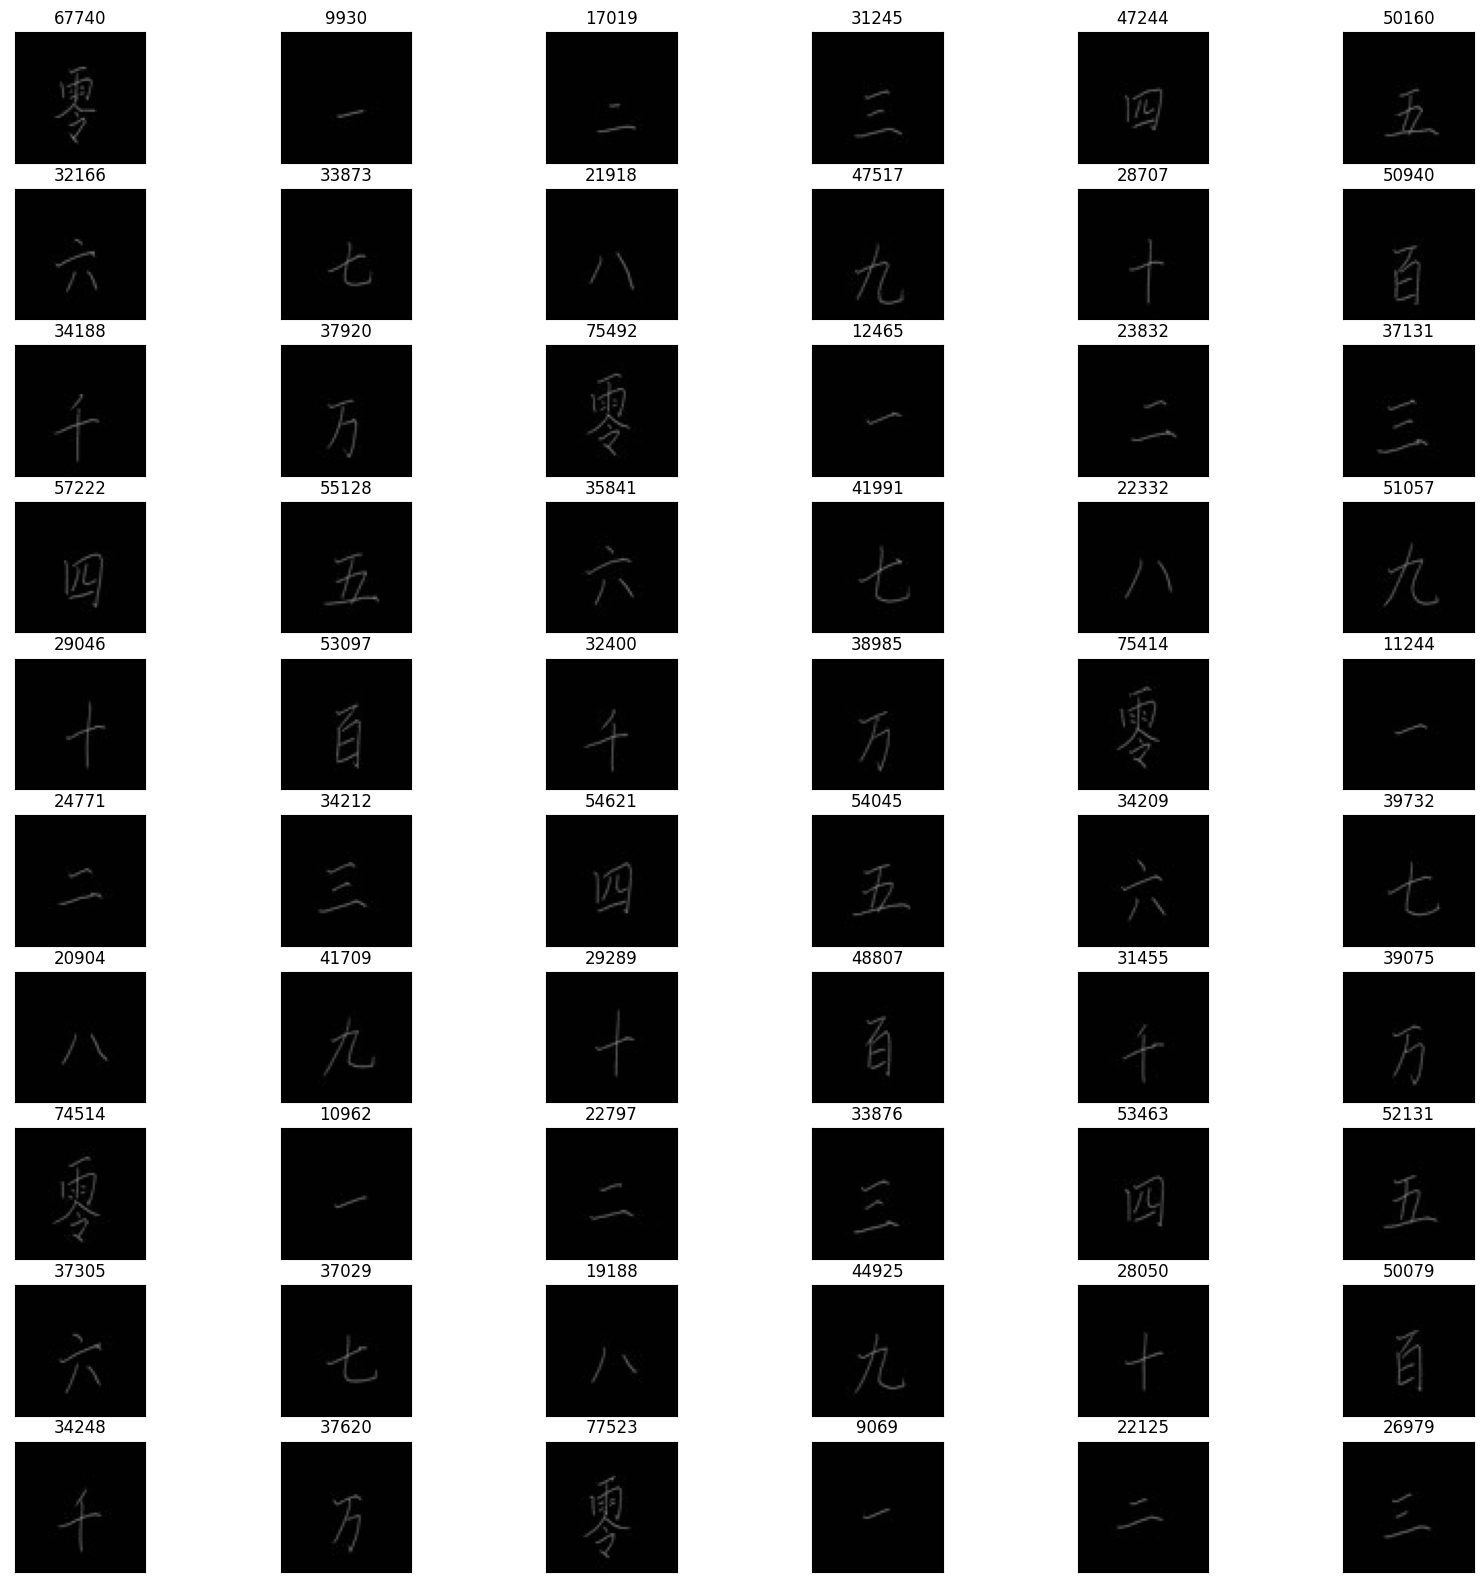

In [302]:
a_train = []
for i in range(1,5):
    for j in range(1,10):
        for k in range(1,15):
            image = io.imread("img_gen/input_" + str(i) + "_" + str(j) + "_" + str(k) + ".jpg", as_gray=False)
            image = color.gray2rgb(image)
            a_train.append(image)
a_train = np.asarray(a_train)
fig = plot.figure(figsize=(20,20))
for row in range(10):
    for column in range(6):
        i = row * 6 + column
        if i>len(a_train)-1:
            break                   
        ax = fig.add_subplot(10, 6, i+1)
        ax.set_title(str(np.sum(a_train[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plot.imshow((a_train[i]/2 + 1).astype(np.uint64))
a_train = np.clip(a_train, -1, 1)
print(a_train.shape)

1/1 [==============================] - 0s 125ms/step
epoch: 0
1/1 [==============================] - 0s 117ms/step


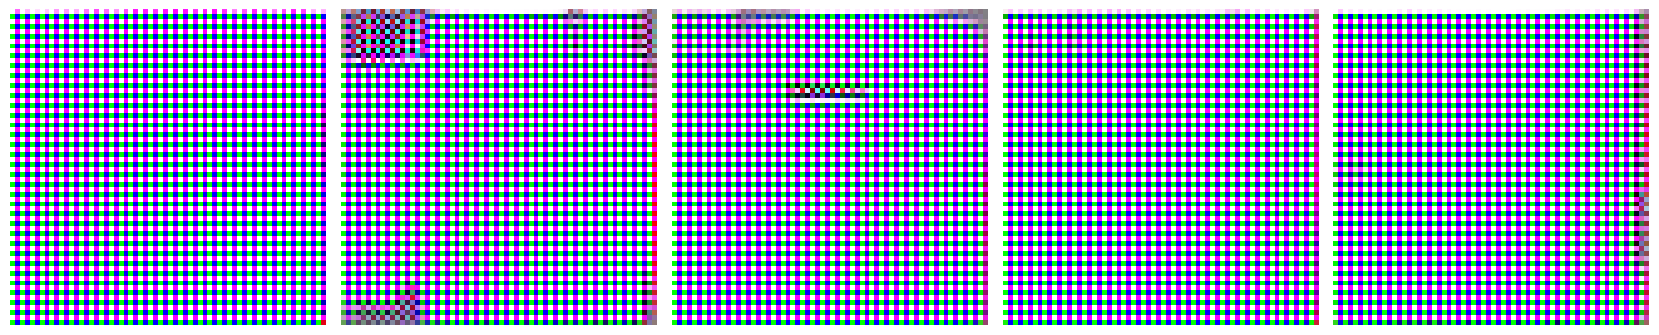

1/1 [==============================] - 0s 133ms/step


KeyboardInterrupt: 

In [304]:
discrim_losses = []
all_images = []
size = 32
num_batches = int(a_train.shape[0] / size)
for ep in range(0, 100):
    for i in range(num_batches):
        noise = np.random.normal(0, 1.0, size=[size, 100])
        image_batch = a_train[np.random.randint(0, a_train.shape[0], size=size)]
        generated_images = model_gen.predict(noise)
        X = np.concatenate([image_batch, generated_images])
        y_dis = np.zeros(2*size)
        y_dis[:size] = 0.60
        y_dis += np.random.uniform(0, 0.1, size = len(y_dis))
        model_discr.trainable = True
        d_loss, _ = model_discr.train_on_batch(X, y_dis)
        discrim_losses.append(d_loss)
        noise = np.random.normal(0, 1.0, size=[size, 100])
        y_gen = np.ones(size) 
        model_discr.trainable = False
        model_gan.train_on_batch(noise, y_gen)
    if ep % 10 == 0:
        print("epoch: " + str(ep))
        num_of_images = 6
        noise = np.random.normal(0, 1.0, size=[size, 100])
        generated_images = model_gen.predict(noise)
        generated_images = np.asarray((generated_images+1)/2.0)
        all_images.append(generated_images)
        plot.figure(figsize=(20, 4))
        for i in range(1, 6):
            plot.subplot(1, 6, i+1)
            plot.imshow(generated_images[i])
            plot.axis('off')
            plot.tight_layout()
        plot.show()
        clear_session()